In [16]:
import numpy as np
import pandas as pd
import gmaps
from keysTkingdom.g_api import gapi_key
import PIL.Image as Image
from IPython.display import display
from IPython.display import SVG

gmaps.configure(api_key=gapi_key)

In [7]:
def convert_to_cartesian(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi /180
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

def convert_to_lat_lon(x, y, z):
    lon = np.arctan2(y, x) * 180 / np.pi
    r = np.sqrt(x **2 + y ** 2)
    lat = np.arctan2(z, r) * 180/ np.pi
    return lat, lon

In [8]:
group_coords = pd.read_csv('./group_coords.csv')

In [9]:
# lazily remove outliers
group_coords = group_coords[group_coords['Unnamed: 0'].str.contains('Brian') == False]

In [10]:
group_coords['Weekday'] = group_coords[[col for col in group_coords.columns if 'Weekday' in col]].apply(lambda x: convert_to_cartesian(*x), axis=1)
group_coords['Weekend'] = group_coords[[col for col in group_coords.columns if 'Weekend' in col]].apply(lambda x: convert_to_cartesian(*x), axis=1)

# Centroid comp

In [11]:
weekday_centroid = tuple(map(np.mean, zip(*group_coords['Weekday'])))
weekend_centroid = tuple(map(np.mean, zip(*group_coords['Weekend'])))
weekday_centroid_coords = convert_to_lat_lon(*weekday_centroid)
weekend_centroid_coords = convert_to_lat_lon(*weekend_centroid)

print(weekday_centroid_coords, weekend_centroid_coords)

(47.636545047074968, -122.26061975008366) (47.636440451974529, -122.27638231601468)


In [12]:
weekday_coords = group_coords[['Weekday - LAT', 'Weekday - LON']].values.tolist()
weekend_coords = group_coords[['Weekend - LAT', 'Weekend - LON']].values.tolist()

In [13]:
m = gmaps.Map()
marker = gmaps.marker_layer([weekend_centroid_coords], label=['end'])
more_markers = gmaps.marker_layer(weekend_coords, label=group_coords['Unnamed: 0'].values)
m.add_layer(marker)
m.add_layer(more_markers)
m

In [14]:
# Image.open('./map_render_weekday.png')

In [15]:
# Image.open('./map_render_weekend.png')

# Find geometric median

## Weiszfeld's algorithm for finding the geometric median:

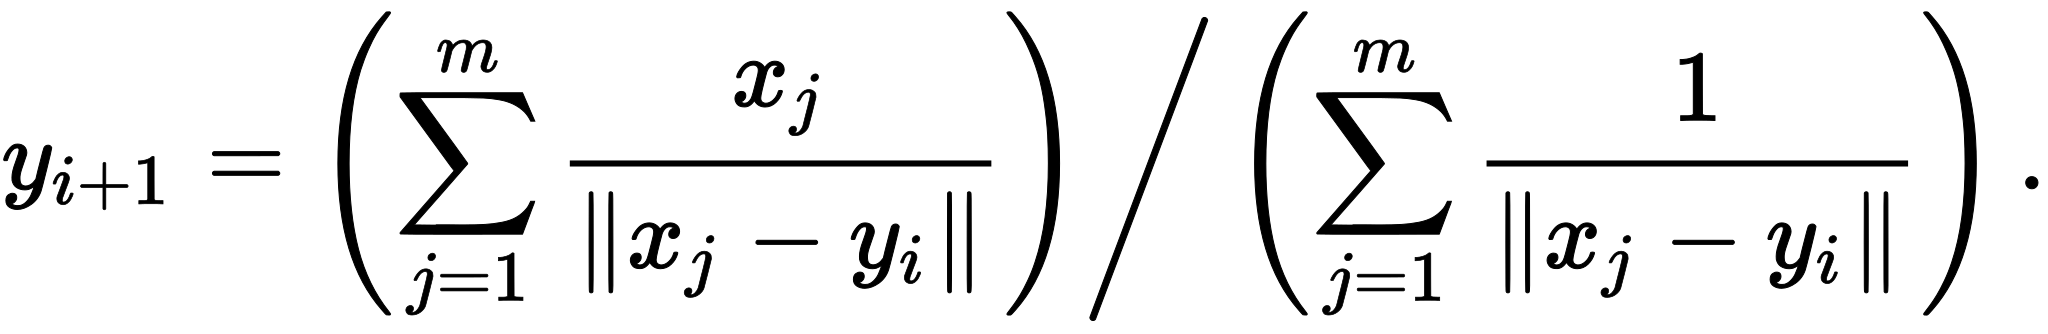

In [17]:
display(SVG(url='https://wikimedia.org/api/rest_v1/media/math/render/svg/b3fb215363358f12687100710caff0e86cd9d26b'))

In [18]:
def update_y(coords, y_i):
    num = coords / np.linalg.norm(coords - y_i, axis=1).reshape(coords.shape[0], 1)
    denom = np.linalg.norm(coords - y_i, axis=1) ** -1
    y_i_plus_1 = num.sum(axis=0) / denom.sum(axis=0)
    return y_i_plus_1


def geo_med_solver(coords, old_y, tol):
    new_y = update_y(coords, old_y)
    while np.linalg.norm(new_y - old_y) > tol:
        old_y = new_y
        new_y = update_y(coords, old_y)
    return new_y

In [22]:
coords = np.array(group_coords['Weekday'].tolist())

term_delta = 1.0 * 10 ** (-8)
geo_median = geo_med_solver(coords, weekend_centroid, term_delta)
geo_med_coords = convert_to_lat_lon(*geo_median.tolist())
geo_med_coords

(47.632175687168917, -122.31230748921591)

In [25]:
m = gmaps.Map()
marker = gmaps.marker_layer([weekend_centroid_coords, geo_med_coords], label=['centroid', 'geo median'])
more_markers = gmaps.marker_layer(weekend_coords, label=group_coords['Unnamed: 0'].values)
m.add_layer(marker)
m.add_layer(more_markers)
m

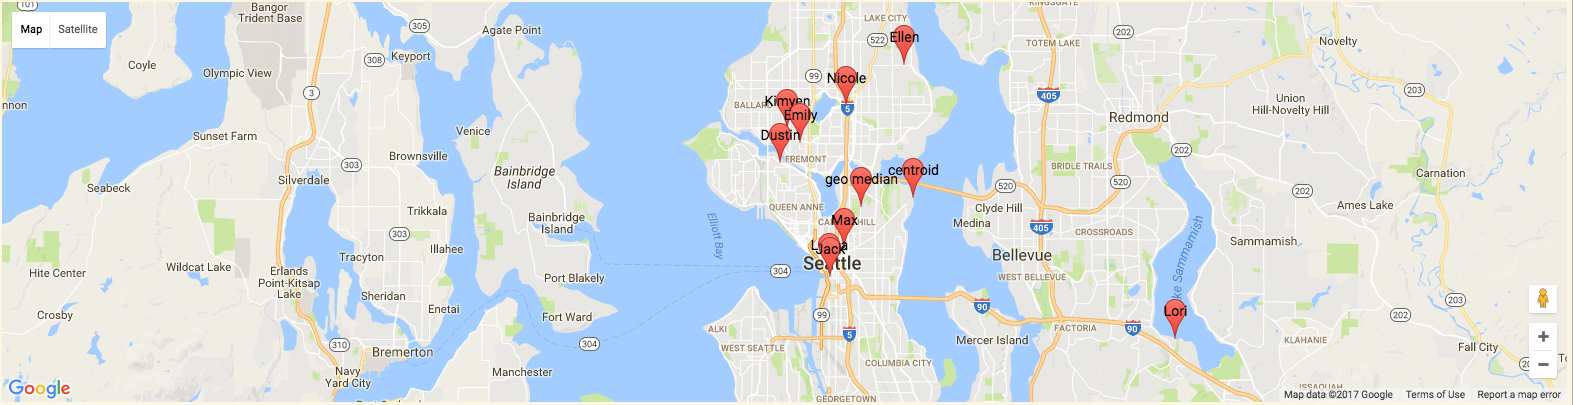

In [26]:
Image.open('./map_render_median.png')